In [1]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm as lgb
import seaborn as sns
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
sns.set(rc={'figure.figsize':(20, 10)})

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
for p in [np, pd, sklearn, scipy, lgb, sns]:
    print (p.__name__, p.__version__)

numpy 1.14.2
pandas 0.23.4
sklearn 0.19.1
scipy 0.19.1
lightgbm 2.1.1
seaborn 0.8.0


# load the data

In [3]:
import os
import tarfile
from six.moves import urllib
PATH = os.path.join("journey", "data")
def load_data(file):
    csv_path = os.path.join(PATH,file)
    return pd.read_csv(csv_path)

In [4]:
import nltk
nltk.download("stopwords")
#--------#

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

#Preprocess function
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

[nltk_data] Downloading package stopwords to C:\Users\Hamza
[nltk_data]     SBAAI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
sales = load_data('sales_train.csv')
shops = load_data('shops.csv')
items = load_data('items.csv')
item_cats = load_data('item_categories.csv')
test = load_data('test.csv')

In [6]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_min,date_max,item_time,item_block,item_shop_block,new_cats,item_category_id,item_price_mean_x,item_cnt_day_mean_x,item_cnt_day_mean_y,item_price_mean_y
0,2013-02-01,0,59,22154,999.0,1.0,2013-01-04,2015-12-07,1067.0,33,0,5,37,656.619707,1.122238,1.015202,514.252938
1,2015-07-21,30,59,21619,499.0,1.0,2013-01-04,2015-12-06,1066.0,33,0,5,37,656.619707,1.122238,1.015202,514.252938
2,2013-08-01,0,59,21759,499.0,1.0,2013-01-02,2015-11-09,1041.0,33,23,5,37,656.619707,1.122238,1.015202,514.252938
3,2013-06-28,5,59,21759,499.0,1.0,2013-01-02,2015-11-09,1041.0,33,23,5,37,656.619707,1.122238,1.015202,514.252938
4,2014-04-11,22,59,21759,199.0,1.0,2013-01-02,2015-11-09,1041.0,33,23,5,37,656.619707,1.122238,1.015202,514.252938


In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [10]:
print("sales----------------------------")
sales.info()
print("shops----------------------------")
shops.info()
print("items----------------------------")
items.info()
print("item_cats----------------------------")
item_cats.info()
print("test----------------------------")
test.info()

sales----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935466 entries, 0 to 2935465
Data columns (total 17 columns):
date                   object
date_block_num         int64
shop_id                int64
item_id                int64
item_price             float64
item_cnt_day           float64
date_min               object
date_max               object
item_time              float64
item_block             int64
item_shop_block        int64
new_cats               int64
item_category_id       int64
item_price_mean_x      float64
item_cnt_day_mean_x    float64
item_cnt_day_mean_y    float64
item_price_mean_y      float64
dtypes: float64(7), int64(7), object(3)
memory usage: 380.7+ MB
shops----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ KB
items-------------------------

# item

In [11]:
items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [13]:
from sklearn.feature_extraction import text

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
bow_converter = CountVectorizer(min_df=100)
x = bow_converter.fit_transform(items['item_name'])
words = bow_converter.get_feature_names()
for i, col in enumerate(words):
    items[col] = pd.SparseSeries(x[:, i].toarray().ravel(), fill_value=0)

* this dataset has a primary key= (item_id)

40    5035
55    2365
37    1780
31    1125
58     790
30     756
72     666
19     628
61     598
23     501
43     471
57     427
56     397
67     394
63     366
76     333
41     332
69     317
38     310
62     295
59     294
64     290
78     278
75     277
28     240
70     228
77     220
45     195
66     178
20     175
49     167
65     163
44     161
47     151
25     140
21     125
24     123
54      90
22      79
2       75
60      52
29      46
11      41
6       40
15      37
73      36
3       34
5       29
68      27
7       24
12      20
16      20
33      18
14      18
4       15
83      15
42      12
9       12
46      12
8        9
82       8
34       8
27       8
74       8
17       7
81       7
39       7
71       6
36       6
32       6
80       6
18       6
13       6
48       5
0        4
35       4
52       3
53       3
26       3
50       2
1        2
51       1
10       1
79       1
Name: item_category_id, dtype: int64


C:\Users\Hamza SBAAI\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


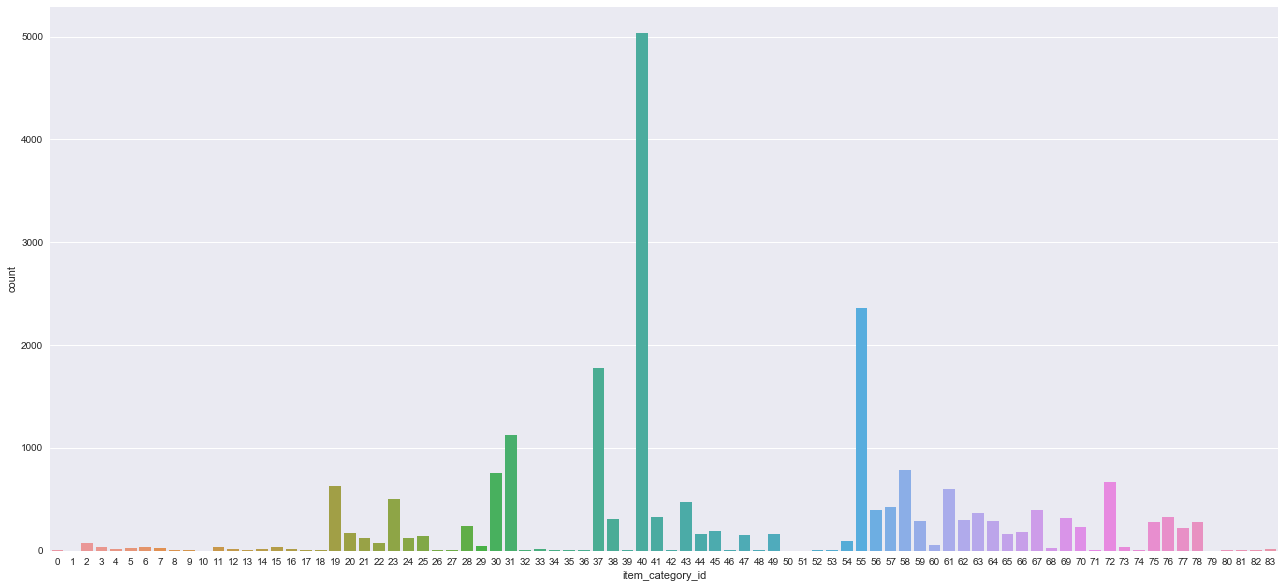

In [16]:
# item_category_id
print(items['item_category_id'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(items['item_category_id'])
plt.show()

# item_cats datasets
 * this dataset is just obout the name of each item_category_id
 * so all we can do with this data is to come up with a new feature 


In [17]:
l=[preprocess_text(i) for i in item_cats.item_category_name]

In [18]:
item_cats['cats'] = l

In [19]:
bow_converter = CountVectorizer(min_df=8)
x = bow_converter.fit_transform(item_cats['cats'])
words = bow_converter.get_feature_names()
len(words)

7

In [20]:
for i, col in enumerate(words):
    item_cats[col] = pd.SparseSeries(x[:, i].toarray().ravel(), fill_value=0)

In [21]:
item_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 10 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
cats                  84 non-null object
аксессуар             84 non-null int64
игра                  84 non-null int64
игровой               84 non-null int64
книга                 84 non-null int64
консоль               84 non-null int64
подарок               84 non-null int64
цифра                 84 non-null int64
dtypes: int64(8), object(2)
memory usage: 2.6+ KB


In [22]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

data = [go.Bar(
            x=item_cats.columns[3:],
            y=[item_cats[c].sum() for c in item_cats.columns[3:]],
            hoverinfo = 'text',
            marker = dict(color = 'rgba(177, 14, 22, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
    )]

layout = dict(
    title = 'sub names appearances',
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [23]:
#item_cats.to_csv('journey/data/new_cats.csv',index=False)

In [24]:
#item_cats=pd.read_csv('journey/data/new_cats.csv')

In [25]:
l=item_cats.cats.str.split()

In [26]:
M=[]
for i in l:
    M=M+[[j for j in i if len(j)>3]]

for i in M:
    for j in range(len(i)):
        if i[j]=='гарнитур':
            i[j]='музыка'
        if i[j]=="билет":
            i[j]='служебный'            

l=[i[0] for i in M]


In [27]:
M

[['музыка', 'наушники'],
 ['аксессуар'],
 ['аксессуар'],
 ['аксессуар'],
 ['аксессуар'],
 ['аксессуар', 'psvita'],
 ['аксессуар', 'xbox'],
 ['аксессуар', 'xbox'],
 ['служебный', 'цифра'],
 ['доставка', 'товар'],
 ['игровой', 'консоль'],
 ['игровой', 'консоль'],
 ['игровой', 'консоль'],
 ['игровой', 'консоль'],
 ['игровой', 'консоль', 'psvita'],
 ['игровой', 'консоль', 'xbox'],
 ['игровой', 'консоль', 'xbox'],
 ['игровой', 'консоль', 'прочий'],
 ['игра'],
 ['игра'],
 ['игра'],
 ['игра'],
 ['игра', 'psvita'],
 ['игра', 'xbox'],
 ['игра', 'xbox'],
 ['игра', 'аксессуар', 'игра'],
 ['игра', 'android', 'цифра'],
 ['игра', 'цифра'],
 ['игра', 'дополнительный', 'издание'],
 ['игра', 'коллекционный', 'издание'],
 ['игра', 'стандартный', 'издание'],
 ['игра', 'цифра'],
 ['карта', 'оплата', 'кино', 'музыка', 'игра'],
 ['карта', 'оплата', 'live'],
 ['карта', 'оплата', 'live', 'цифра'],
 ['карта', 'оплата'],
 ['карта', 'оплата', 'windows', 'цифра'],
 ['кино'],
 ['кино'],
 ['кино'],
 ['кино'],
 ['ки

In [28]:
from sklearn.preprocessing import LabelEncoder

In [29]:
item_cats["new_cats"]= LabelEncoder().fit_transform(l)


In [30]:
#item_cats.to_csv('journey/data/new_cats.csv',index=False)

### now lets merge those two datasets 


In [31]:
item_to_cat_df = items.merge(item_cats, how="inner", on="item_category_id")[['item_id',"item_category_id",'cats']]
item_to_cat_df.head()

,item_id,item_category_id,cats
0,0,40,кино dvd
1,2,40,кино dvd
2,3,40,кино dvd
3,4,40,кино dvd
4,5,40,кино dvd


музыка музыкальный видео              1
игра xbox 360                         1
доставка товар                        1
кино коллекционный                    1
игровой консоль ps4                   1
игра pc дополнительный издание        1
игровой консоль прочий                1
карта оплата windows цифра            1
подарок фигурка                       1
игра psp                              1
программа обучать цифра               1
книга артбук энциклопедия             1
игра psvita                           1
программа 1с предприятие 8            1
игра ps4                              1
чистый носитель шпиль                 1
игровой консоль ps3                   1
кино blu ray 3d                       1
элемент питание                       1
игра pc коллекционный издание         1
игровой консоль ps2                   1
кино blu ray                          1
книга аудиокнига цифра                1
игровой консоль psvita                1
аксессуар xbox one                    1


C:\Users\Hamza SBAAI\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



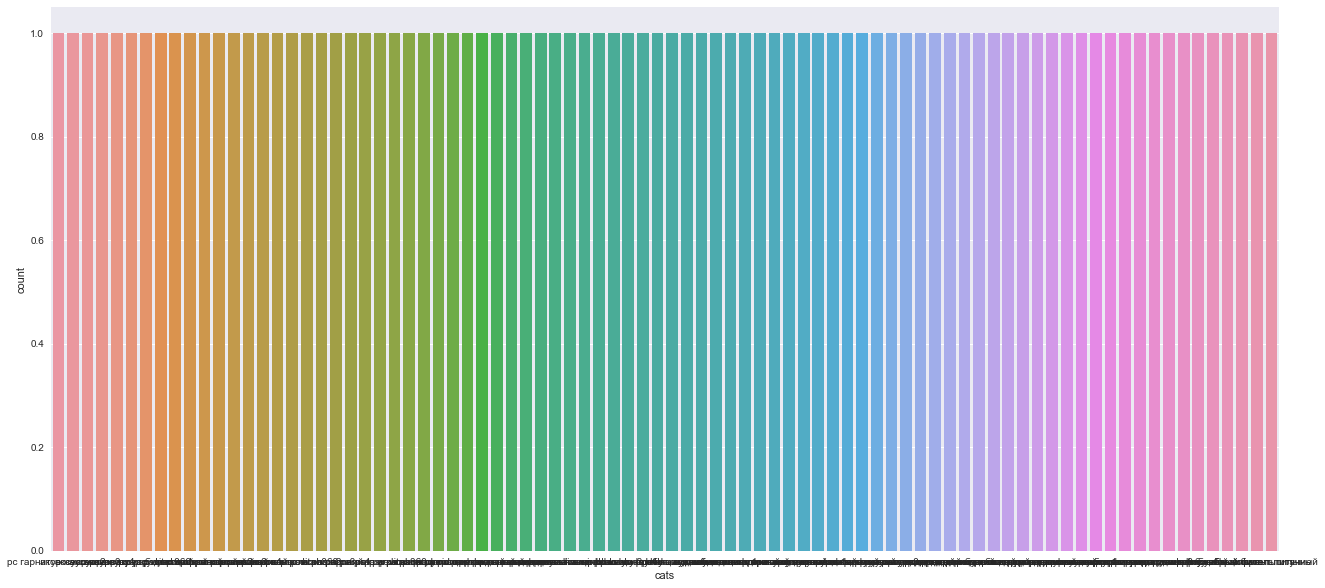

In [32]:
print(item_cats['cats'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(item_cats['cats'])
plt.show()

In [33]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
data =item_to_cat_df['cats'].value_counts()
print(data)
data = [go.Bar(
            x=data.index,
            y=data.values,
            hoverinfo = 'text',
            marker = dict(color = 'rgba(177, 14, 22, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
    )]

layout = dict(
    title = 'categories',
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

кино dvd                              5035
музыка cd локальный производство      2365
кино blu ray                          1780
игра pc цифра                         1125
музыка винить                          790
игра pc стандартный издание            756
подарок фигурка                        666
игра ps3                               628
подарок атрибутика                     598
игра xbox 360                          501
книга аудиокнига                       471
музыка mp3                             427
музыка cd фирменный производство       397
подарок развитие                       394
подарок мягкий игрушка                 366
программа дом офис цифра               333
кино коллекционный                     332
подарок сувенир                        317
кино blu ray 3d                        310
подарок гаджет робот спорт             295
музыка музыкальный видео               294
подарок настольный игра                290
программа обучать цифра                278
программа д

In [34]:
from sklearn.feature_extraction import FeatureHasher
fh = FeatureHasher(n_features=5, input_type='string')
hashed_features = fh.fit_transform(item_cats['cats'])
hashed_features = hashed_features.toarray()
df=pd.concat([item_cats[['item_category_id', 'cats']], pd.DataFrame(hashed_features)], 
          axis=1)

In [35]:
df.head()

,item_category_id,cats,0,1,2,3,4
0,0,pc гарнитур наушники,0.0,-6.0,1.0,1.0,-2.0
1,1,аксессуар ps2,-3.0,-1.0,1.0,-1.0,-3.0
2,2,аксессуар ps3,-2.0,-2.0,1.0,-1.0,-3.0
3,3,аксессуар ps4,-3.0,-2.0,0.0,-1.0,-3.0
4,4,аксессуар psp,-3.0,-3.0,1.0,-1.0,-3.0


# shops datasets
 * same as item_cats datasets 
 * this dataset is just obout the name of each shop
 * so all we can do with this data is to come up with a new feature 


In [114]:
shops.shape

(60, 2)

#Several shops are duplicates of each other (according to its name). Fix train and test set.

In [115]:
# Якутск Орджоникидзе, 56
shops.loc[shops.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
shops.loc[shops.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
shops.loc[shops.shop_id == 10, 'shop_id'] = 11

#### max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:

* max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
* max_df = 25 means "ignore terms that appear in more than 25 documents".

The default max_df is 1.0, which means "ignore terms that appear in more than  100% of the documents". Thus, the default setting does not ignore any terms.

#### min_df is used for removing terms that appear too infrequently. For example:

* min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
* min_df = 5 means "ignore terms that appear in less than 5 documents".

The default min_df is 1, which means "ignore terms that appear in less than 1    document". Thus, the default setting does not ignore any terms.**

In [122]:
shops.shop_name.unique()

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва Т

* we should clean filter shops names before encoding them

In [123]:
l=[preprocess_text(i) for i in shops.shop_name]

In [124]:
shops["name"]=l

* Each shop_name contain  the city name.

shops['name'].unique()

In [154]:
russian_cities=pd.read_csv("rocid.csv/city.csv",sep=';' , encoding="windows-1251" )
name=shops['name'].str.split(' ')
l=[]
for m in list(name):
    a=""
    for j in m:
        if j.capitalize() in list(russian_cities.name):
            a= a+j.capitalize()+" "
            
    l=l+[a]

shops['city']=l
shops['city']=shops['city'].str.split(' ').map(lambda x: x[0])

shops['city1'] = shops['name'].str.split(' ').map(lambda x: x[0])


shops.city[shops[shops['city']==""].index]=shops.city1[shops[shops['city']==""].index]

In [171]:
shops.city

0          Якутск
1          Якутск
2          адыгея
3        Балашиха
4        Волжский
5         Вологда
6         Воронеж
7         Воронеж
8         Воронеж
9        выездной
10      Жуковский
11      Жуковский
12       интернет
13         Казань
14         Казань
15         Калуга
16        Коломна
17     Красноярск
18     Красноярск
19          Курск
20         Москва
21         Москва
22         Москва
23         Москва
24         Москва
25         Москва
26         Москва
27         Москва
28         Москва
29         Москва
30         Москва
31         Москва
32         Москва
33         Мытищи
34       Новгород
35       Новгород
36    Новосибирск
37    Новосибирск
38           Омск
39    ростовнадон
40    ростовнадон
41    ростовнадон
42            спб
43            спб
44         Самара
45         Самара
46        сергиев
47         Сургут
48          Томск
49         Тюмень
50         Тюмень
51         Тюмень
52            Уфа
53            Уфа
54          Химки
55       ц

In [172]:

shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]



In [175]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
data =shops['city_code'].value_counts()
print(data)
data = [go.Bar(
            x=data.index,
            y=data.values,
            hoverinfo = 'text',
            marker = dict(color = 'rgba(177, 14, 22, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
    )]

layout = dict(
    title = 'categories',
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

10    13
22     4
27     3
3      3
18     3
15     2
19     2
13     2
29     2
8      2
12     2
5      2
4      2
7      1
11     1
9      1
2      1
1      1
6      1
30     1
14     1
16     1
17     1
20     1
21     1
23     1
24     1
25     1
26     1
28     1
0      1
Name: city_code, dtype: int64


In [176]:
shops.to_csv('journey/data/new_shops.csv',index=False)

### it looks like we have outliers on item_cnt_day and item_price